# 4b. Deploying Your Model


### Google Colab Setup
First off, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section, but you will need to use the environment.yaml file to set up your Python environment and use it for your Jupyter kernel.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now remember the path in your Google Drive where you uploaded this notebook, fill it in below. If all functions properly, executing the next cell should display the filenames from the assignment:

```
['03_asl_cnn.ipynb', 'data', 'images', '02_asl.ipynb', '01_mnist.ipynb']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'CS5388_PyTorch1'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

In [ ]:
import sys

sys.path.append(GOOGLE_DRIVE_PATH)

### Local Setup OR Google Drive
Run the cell below regardless of whether you are using google drive or local setup.

In [ ]:
# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Now that we have a well trained model, it's time to use it. In this exercise, we'll expose new images to our model and detect the correct letters of the sign language alphabet. Let's get started!

## 4b.1 Objectives

* Load an already-trained model from disk
* Reformat images for a model trained on images of a different format
* Perform inference with new images, never seen by the trained model and evaluate its performance

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

/Users/splineguy/anaconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/splineguy/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

False

## 4b.2 Loading the Model
Now that we're in a new notebook, let's load the saved model that we trained. Our save from the previous exercise created a folder called "asl_model". We can load the model by selecting the same folder.

Since our model uses a [custom module](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html), we will need to load the code for that class. We have saved a copy of the code in [utils.py](./uitls.py).

In [2]:
from utils import MyConvBlock

Now that we have a definition for `MyConvBlock`, we can use [torch.load](https://pytorch.org/docs/stable/generated/torch.load.html) to load a model from a path. We can use `map_location to specify the device. When we print the model, does it look the same as in the last notebook?

In [4]:
model = torch.load('model.pth', map_location=device)
model

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

We can also verify if the model is on our GPU.

In [5]:
next(model.parameters()).device

device(type='cpu')

## 4b.3 Preparing an Image for the Model

It's now time to use the model to make predictions on new images that it's never seen before. This is also called inference. We have a set of images in the `data/asl_images` folder. Try opening it using the left navigation and explore the images.

You'll notice that the images we have are much higher resolution than the images in our dataset. They are also in color. Remember that our images in the dataset were 28x28 pixels and grayscale. It's important to keep in mind that whenever we make predictions with a model, the input must match the shape of the data that the model was trained on. For this model, the training dataset was of the shape: (27455, 28, 28, 1). This corresponded to 27455 images of 28 by 28 pixels each with one color channel (grayscale).

### 4b.3.1 Showing the Images

When we use our model to make predictions on new images, it will be useful to show the image as well. We can use the matplotlib library to do this.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

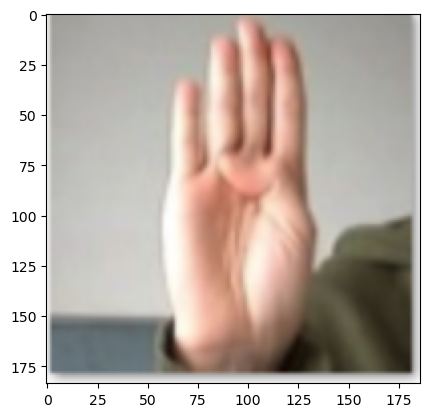

In [7]:
show_image('data/asl_images/b.png')

### 4b.3.2 Scaling the Images

The images in our dataset were 28x28 pixels and grayscale. We need to make sure to pass the same size and grayscale images into our method for prediction. There are a few ways to edit images with Python, but TorchVision also has the [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html) function. We can let it know what kind of image to read with [ImageReadMode](https://pytorch.org/vision/stable/generated/torchvision.io.ImageReadMode.html#torchvision.io.ImageReadMode).

In [8]:
image = tv_io.read_image('data/asl_images/b.png', tv_io.ImageReadMode.GRAY)
image

tensor([[[247, 223, 178,  ..., 223, 231, 238],
         [245, 221, 178,  ..., 213, 223, 232],
         [244, 220, 177,  ..., 204, 217, 228],
         ...,
         [247, 243, 238,  ..., 223, 231, 238],
         [249, 246, 243,  ..., 232, 238, 243],
         [250, 248, 246,  ..., 240, 243, 246]]], dtype=torch.uint8)

Let's look at the shape of the image.

In [9]:
image.shape

torch.Size([1, 184, 186])

This image is much larger than what we trained on. We can use [TorchVision](https://pytorch.org/vision/stable/index.html)'s [Transforms](https://pytorch.org/vision/0.9/transforms.html) again to get the data in the form our model expects.

We will:
* Convert the image to float with [ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html)
  * We will set `scale` to `True` in order to convert from [0, 255] to [0, 1]
* [Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Resize.html#torchvision.transforms.v2.Resize) the image to be 28 x 28 pixels
* Convert the images to [Grayscale](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Grayscale.html#torchvision.transforms.v2.Grayscale)
  * This step doesn't do anything since our models are already grayscale, but we've added it here to show an alternative way to get grayscale images.

In [11]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

TypeError: ToDtype.__init__() got an unexpected keyword argument 'scale'

Let's test `preprocess_trans` on an image to make sure it works correctly:

In [ ]:
processed_image = preprocess_trans(image)
processed_image

The numbers look correct, but how about the shape?

In [ ]:
processed_image.shape

Next, let's plot the image to see if it looks like what we trained on.

In [ ]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

Looking good! Let's pass it to our model.

### 4b.4 Making Predictions

Okay, now we're ready to predict! Our model still expects a batch of images. If the [squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.htmlhttps://pytorch.org/docs/stable/generated/torch.squeeze.html) removes dimensions of 1, [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.htmlhttps://pytorch.org/docs/stable/generated/torch.unsqueeze.html) adds a dimension of 1 at the index we specify. The first dimension is usually the batch dimension, so we can say `.unsqueeze(0)`.

In [ ]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

Next, we should make sure the input tensor is on the same `device` as the model.

In [ ]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

Now we're ready to pass it to the model!

In [ ]:
output = model(batched_image_gpu)
output

### 4b.4.1 Understanding the Prediction

The predictions are in the format of a 24 length array. The larger the value, the more likely the input image belongs to the corresponding class. Let's make it a little more readable. We can start by finding which element of the array represents the highest probability. This can be done easily with the numpy library and the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [ ]:
prediction = output.argmax(dim=1).item()
prediction

Each element of the prediction array represents a possible letter in the sign language alphabet. Remember that j and z are not options because they involve moving the hand, and we're only dealing with still photos. Let's create a mapping between the index of the predictions array, and the corresponding letter.

In [ ]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

We can now pass in our prediction index to find the corresponding letter.

In [ ]:
alphabet[prediction]

#### Exercise: Put it all Together

Let's put everything in a function so that we can make predictions just from the image file. Implement it in the function below using the functions and steps above. If you need help, you can reveal the solution by clicking the three dots below.

In [ ]:
def predict_letter(file_path):
    # Show image
    FIXME
    # Load and grayscale image
    image = FIXME
    # Transform image
    image = FIXME
    # Batch image
    image = FIXME
    # Send image to correct device
    image = FIXME
    # Make prediction
    output = FIXME
    # Find max index
    prediction = FIXME
    # Convert prediction to letter
    predicted_letter = FIXME
    # Return prediction
    return predicted_letter

#### Solution

Click on the '...' below to view the solution.

In [ ]:
# SOLUTION
def predict_letter(file_path):
    show_image(file_path)
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    image = preprocess_trans(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    prediction = output.argmax(dim=1).item()
    # convert prediction to letter
    predicted_letter = alphabet[prediction]
    return predicted_letter

In [ ]:
predict_letter("data/asl_images/b.png")

Let's also use the function with the 'a' letter in the asl_images datset:

In [ ]:
predict_letter("data/asl_images/a.png")

## 4b.5 Summary

Great work on these exercises! You've gone through the full process of training a highly accurate model from scratch, and then using the model to make new and valuable predictions. If you have some time, we encourage you to take pictures with your webcam, upload them by dropping them into the data/asl_images folder, and test out the model on them. For Mac you can use Photo Booth. For windows you can select the Camera app from your start screen. We hope you try it. It's a good opportunity to learn some sign language! For instance, try out the letters of your name.

We can imagine how this model could be used in an application to teach someone sign language, or even help someone who cannot speak interact with a computer.